# Deep Convolutional Generative Adversarial Networks

[Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) is a model which is capable of learning resuable feature representations from large unlabeled image datasets. It helps bridge the gap between the success of CNNs for supervised learning and unsupervised learning. 

In this tutorial, we'll use DCGAN model to train on [LWF Face Dataset](http://vis-www.cs.umass.edu/lfw/), which contains about 13000 images of faces. We'll see that good image representation can be built by GAN and our model is capable of generating photo-realistic human face images.


In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

## Set Training parameters

In [2]:
epochs = 100
batch_size = 64
latent_z_size = 100

num_gpu = 2
ctx = [mx.cpu()] if num_gpu <= 0 else [mx.gpu(i) for i in range(num_gpu)]

lr = 0.0002
beta1 = 0.5

## Download and preprocess LWF Face Dataset

In [3]:

lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

We first resize images to size 64*64. Then normalize image pixel values to be between -1 and 1.

In [4]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3) 
    # to (3, target_wd, target_ht)
    data = mx.nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = mx.nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

Visualize 4 images:

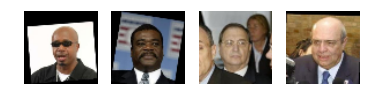

In [5]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

## Defining the networks

The core to DCGAN architecture is adopting and modifying CNN architecture:
* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

* Use batchnorm in both the generator and the discriminator.

* Remove fully connected hidden layers for deeper architectures.

* Use ReLU activation in generator for all layers except for the output, which uses Tanh.

* Use LeakyReLU activation in the discriminator for all layers.

![alt text](img/dcgan.png "DCGAN Architecture")

In [6]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

## Setup Loss Function and Optimizer
We use softmax cross entropy as loss function and adam as optimizer. Initialize parameters with normal distribution.

In [7]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

## Training Loop
We recommend to use gpu to boost training. After a few epochs, we can see human-face-like images are generated

In [8]:
from datetime import datetime
import time
import logging

real_label = utils.split_and_load(mx.nd.ones((batch_size,)), ctx)
fake_label = utils.split_and_load(mx.nd.zeros((batch_size,)), ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = utils.split_and_load(batch.data[0], ctx)
        latent_z = utils.split_and_load(mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1)), ctx)

        with autograd.record():
            # train with real image
            outputs = [netD(data_slice).reshape((-1, 1)) for data_slice in data]
            errD_real = [loss(output, r_label_slice) for output, r_label_slice in zip(outputs, real_label)]
            metric.update(real_label, outputs)

            # train with fake image
            fakes = [netG(latent_z_slice) for latent_z_slice in latent_z]
            outputs = [netD(fake_slice).reshape((-1, 1)) for fake_slice in fakes]
            errD_fake = [loss(output, f_label_slice) for output, f_label_slice in zip(outputs, fake_label)]
            errD = [errD_r + errD_f for errD_r, errD_f in zip(errD_real, errD_fake)]
            for err in errD:
                err.backward()
            metric.update(fake_label, outputs)

        trainerD.step(batch.data[0].shape[0], ignore_stale_grad=True)

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fakes = [netG(latent_z_slice) for latent_z_slice in latent_z]
            outputs = [netD(fake_slice).reshape((-1, 1)) for fake_slice in fakes]
            errG = [loss(output, r_label_slice) for output, r_label_slice in zip(outputs, real_label)]
            for err in errG:
                err.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d' 
                     %(nd.mean(nd.concatenate(errD)).asscalar(), 
                       nd.mean(nd.concatenate(errG)).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fakes[0][0]
    visualize(fake_img)
    plt.show()

## results
Generate some face images with generator.


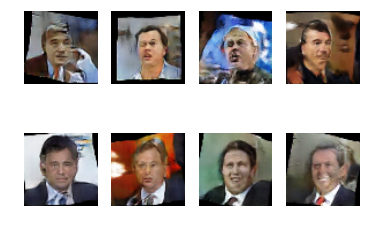

In [9]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx[0])
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

Walk in the latent space. We can see that small changes in the latent space result in smooth changes in generated images. This is a good sign that the model has learnt relevant and interesting representations.

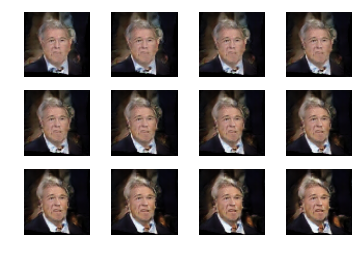

In [10]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx[0])
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()